In [123]:
import pandas as pd
import numpy as np
from typing import Optional
from IPython.utils import io
import matplotlib.pyplot as plt
import seaborn as sns

In [124]:
file_name = "train_cleaned.csv"
df = pd.read_csv(file_name)

In [125]:
df.head()

,customer_id,month,age,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,...,has_credit_builder_loan,has_debt_consolidation_loan,has_home_equity_loan,has_mortgage_loan,has_not_specified,has_payday_loan,has_personal_loan,has_student_loan,credit_history_months,month_num
0,CUS_0x1000,August,18,30625.94,2706.161667,6,5,27.0,2,57,...,1,0,1,0,0,0,0,0,129,8
1,CUS_0x1009,August,26,37550.74,4250.390000,6,5,17.0,4,5,...,1,0,1,0,1,1,0,0,372,8
2,CUS_0x100b,August,19,113781.39,9549.782500,1,4,1.0,0,14,...,0,0,0,0,0,0,0,0,190,8
3,CUS_0x1011,August,44,58918.47,5208.872500,3,3,17.0,3,27,...,1,1,0,0,0,0,0,1,190,8
4,CUS_0x1013,August,44,98620.98,3093.745000,3,3,6.0,3,12,...,0,1,0,0,0,0,1,1,214,8


Here is a **feature engineering checklist** tailored to your dataset (`train_cleaned.csv`):

---

### **7. Outlier and Scaling Step**

* [ ] Log-transform skewed numeric columns:

  ```python
  skewed = ['outstanding_debt', 'annual_income', 'amount_invested_monthly']
  for col in skewed:
      df[col] = np.log1p(df[col])
  ```
* [ ] Normalize or standardize continuous variables for models sensitive to scale (e.g., Logistic Regression).

---

### **8. Feature Selection / Predictive Signal**

After feature creation:

* [ ] Train baseline model (e.g., XGBoost or RandomForest)
* [ ] Evaluate **feature importance**:

  ```python
  from sklearn.inspection import permutation_importance
  r = permutation_importance(model, X, y, n_repeats=5)
  ```
* [ ] Drop low-importance or redundant (correlated) features:

  ```python
  corr = X.corr().abs()
  high_corr = [col for col in corr.columns if any(corr[col] > 0.9)]
  ```

---

### **9. Monitoring-Ready Features**

* [ ] Keep summary stats (mean, std, missing count) for key features
* [ ] Define drift thresholds (e.g., PSI > 0.2 → retrain trigger)

---

Would you like me to output this as a **ready-to-run notebook skeleton (Python code)** that implements each section?


### Derive features
Before adding derived features, we should compute correlation matrix.

In [126]:
multi_collinearity_threshold = 0.8

STEP 1: Baseline Correlation Analysis (Before Feature Engineering)

Top 15 Features Correlated with Credit Score:
credit_score_numeric        1.000000
credit_history_months       0.334869
monthly_balance             0.173769
monthly_inhand_salary       0.170834
amount_invested_monthly     0.139636
annual_income               0.130038
age                         0.114208
credit_utilization_ratio    0.035235
total_emi_per_month         0.013638
interest_rate               0.013338
num_credit_inquiries       -0.007500
has_not_specified          -0.117951
has_mortgage_loan          -0.120735
has_home_equity_loan       -0.123083
has_payday_loan            -0.123898
Name: credit_score_numeric, dtype: float64


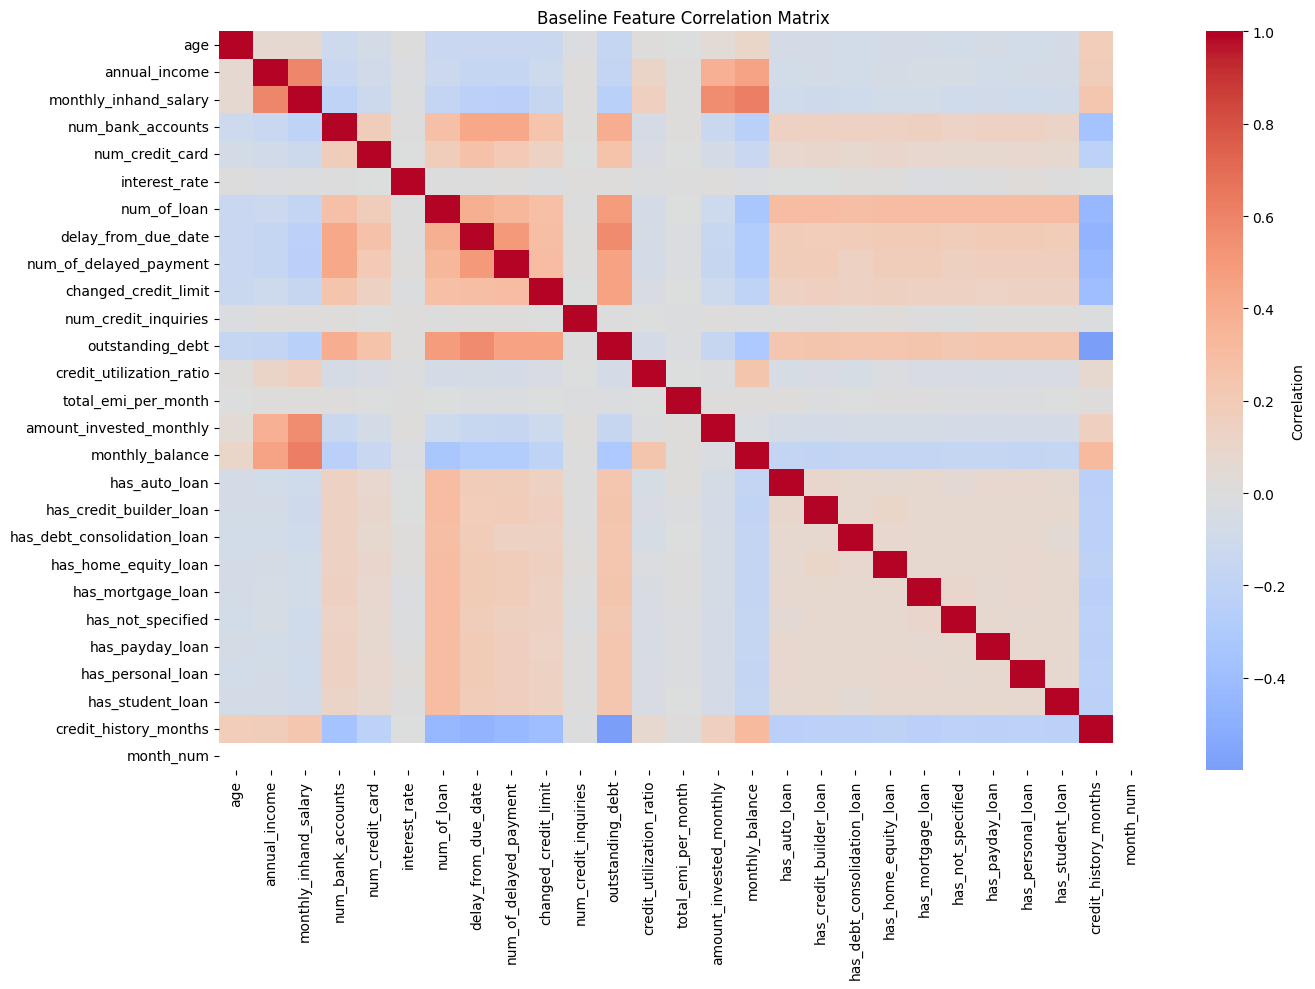


STEP 2: High Multicollinearity Detection (corr > 0.8)

Found 0 highly correlated pairs:
Empty DataFrame
Columns: [feature_1, feature_2, correlation]
Index: []


In [127]:
# Visualize baseline correlations with target
print("=" * 60)
print("STEP 1: Baseline Correlation Analysis (Before Feature Engineering)")
print("=" * 60)

# Convert credit_score to numeric for correlation
credit_score_map = {'Poor': 1, 'Standard': 2, 'Good': 3}
df['credit_score_numeric'] = df['credit_score'].map(credit_score_map)

# Select only numeric columns for correlation
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('credit_score_numeric')  # Separate target

# Compute correlation with target
correlations = df[numeric_cols + ['credit_score_numeric']].corr()['credit_score_numeric'].sort_values(ascending=False)

print("\nTop 15 Features Correlated with Credit Score:")
print(correlations.head(15))

# Visualize correlation matrix
plt.figure(figsize=(14, 10))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, cbar_kws={'label': 'Correlation'})
plt.title('Baseline Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Identify high multicollinearity pairs (before adding ratios)
print("\n" + "=" * 60)
print(f"STEP 2: High Multicollinearity Detection (corr > {multi_collinearity_threshold})")
print("=" * 60)

def find_high_correlation_pairs(corr_matrix, threshold=0.9):
    """Find feature pairs with correlation > threshold"""
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append({
                    'feature_1': corr_matrix.columns[i],
                    'feature_2': corr_matrix.columns[j],
                    'correlation': corr_matrix.iloc[i, j]
                })

    # Handle empty case
    if not high_corr_pairs:
        return pd.DataFrame(columns=['feature_1', 'feature_2', 'correlation'])

    return pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False, key=abs)

high_corr_baseline = find_high_correlation_pairs(corr_matrix, threshold=multi_collinearity_threshold)
print(f"\nFound {len(high_corr_baseline)} highly correlated pairs:")
print(high_corr_baseline)

Finding zero highly correlated pairs (threshold 0.8) is actually ideal for feature engineering. It means:
- No redundancy yet — Your baseline features are relatively independent
- Safe to add ratios — New derived features won't immediately create multicollinearity
- Maximum signal gain — Ratios will capture non-linear relationships without overlap

#### Proceed with Adding Derived Features

In [128]:
# Add Derived Numeric Ratios
print("\n" + "=" * 60)
print("Add Derived Numeric Ratios")
print("=" * 60)

# Financial health ratios
df['income_to_emi_ratio'] = df['annual_income'] / (df['total_emi_per_month'] * 12 + 1)
df['income_to_debt_ratio'] = df['annual_income'] / (df['outstanding_debt'] + 1)
df['salary_to_loan_ratio'] = df['monthly_inhand_salary'] / (df['num_of_loan'] + 1)
df['investment_to_salary_ratio'] = df['amount_invested_monthly'] / (df['monthly_inhand_salary'] + 1)

# Credit behavior ratios
df['avg_delay_days'] = df['delay_from_due_date'] / (df['num_of_delayed_payment'] + 1)
df['credit_inquiries_per_loan'] = df['num_credit_inquiries'] / (df['num_of_loan'] + 1)

# Credit utilization features
df['is_high_utilization'] = (df['credit_utilization_ratio'] > 0.8).astype(int)

# Verify no NaNs introduced
nan_counts = df.select_dtypes(include=[np.number]).isna().sum()
if nan_counts.sum() > 0:
    print(f"\nWarning: {nan_counts.sum()} NaN values found in numeric columns")
    print(nan_counts[nan_counts > 0])
else:
    print("\nNo NaN values in numeric columns")

print(f"\nNew dataset shape: {df.shape}")


Add Derived Numeric Ratios

No NaN values in numeric columns

New dataset shape: (12500, 66)



Multicollinearity Check (After Feature Engineering)

Found 0 highly correlated pairs (threshold 0.8):
✓ No high multicollinearity detected — safe to proceed!

New Features' Correlation with Target

Correlation of New Features with Credit Score:
credit_score_numeric          1.000000
salary_to_loan_ratio          0.203188
income_to_emi_ratio           0.094172
income_to_debt_ratio          0.043522
credit_inquiries_per_loan     0.015651
investment_to_salary_ratio   -0.033294
avg_delay_days               -0.108588
Name: credit_score_numeric, dtype: float64


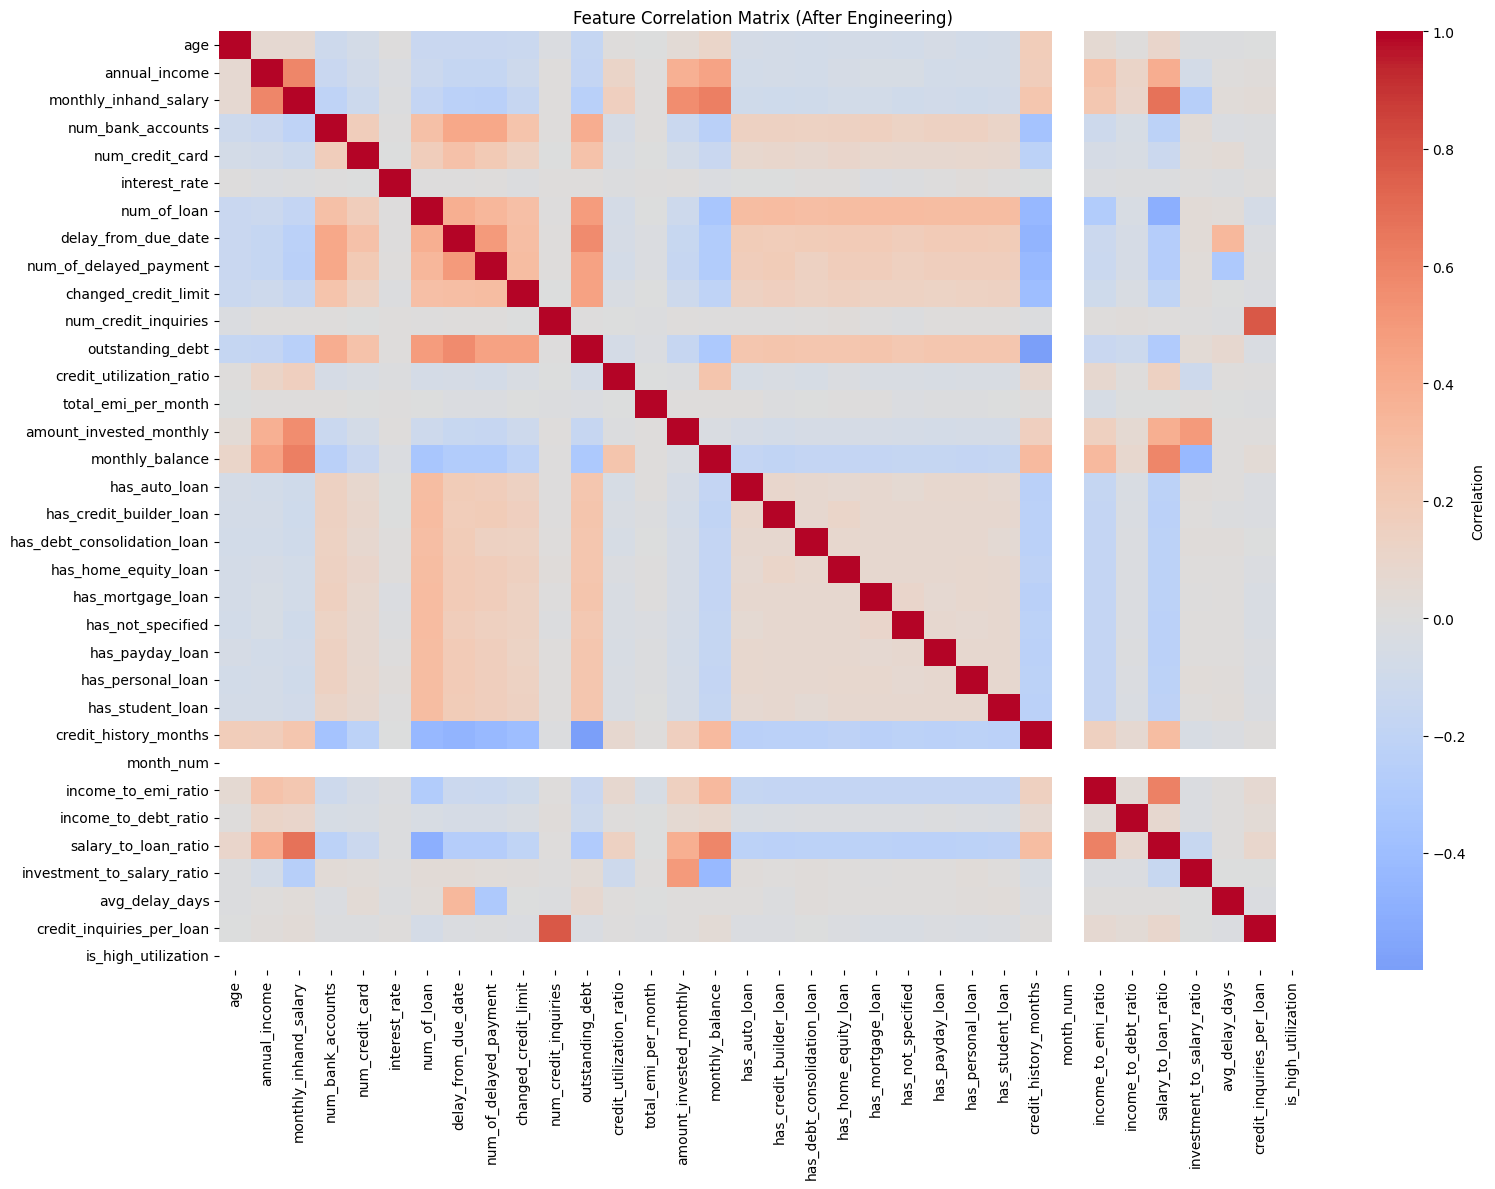

In [129]:
# Check multicollinearity after adding derived features
print("\n" + "=" * 60)
print("Multicollinearity Check (After Feature Engineering)")
print("=" * 60)

numeric_cols_after = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols_after.remove('credit_score_numeric')

corr_matrix_after = df[numeric_cols_after].corr()
high_corr_after = find_high_correlation_pairs(corr_matrix_after, threshold=multi_collinearity_threshold)

print(f"\nFound {len(high_corr_after)} highly correlated pairs (threshold {multi_collinearity_threshold}):")
if len(high_corr_after) > 0:
    print(high_corr_after)
else:
    print("✓ No high multicollinearity detected — safe to proceed!")

# Check correlation of new features with target
print("\n" + "=" * 60)
print("New Features' Correlation with Target")
print("=" * 60)

new_features = [
    'income_to_emi_ratio', 'income_to_debt_ratio', 'salary_to_loan_ratio',
    'investment_to_salary_ratio', 'avg_delay_days', 'credit_inquiries_per_loan',
    'is_high_utilization'
]

new_feature_corrs = df[new_features + ['credit_score_numeric']].corr()['credit_score_numeric'].sort_values(ascending=False)

print("\nCorrelation of New Features with Credit Score:")
print(new_feature_corrs[:-1])  # Exclude credit_score_numeric itself

# Visualize updated correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix_after, annot=False, cmap='coolwarm', center=0, cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Matrix (After Engineering)')
plt.tight_layout()
plt.show()

### One-Hot Encoding
Verify that all features have one-hot encoding.

In [130]:
# show all rows (persist until you reset)
pd.set_option('display.max_rows', 200)
df.head(1).T

,0
customer_id,CUS_0x1000
month,August
age,18
annual_income,30625.94
monthly_inhand_salary,2706.161667
num_bank_accounts,6
num_credit_card,5
interest_rate,27.0
num_of_loan,2
delay_from_due_date,57


In [131]:
pd.set_option('display.max_rows', 200)
list(zip(df.dtypes, df.columns))

[(dtype('O'), 'customer_id'),
 (dtype('O'), 'month'),
 (dtype('int64'), 'age'),
 (dtype('float64'), 'annual_income'),
 (dtype('float64'), 'monthly_inhand_salary'),
 (dtype('int64'), 'num_bank_accounts'),
 (dtype('int64'), 'num_credit_card'),
 (dtype('float64'), 'interest_rate'),
 (dtype('int64'), 'num_of_loan'),
 (dtype('int64'), 'delay_from_due_date'),
 (dtype('int64'), 'num_of_delayed_payment'),
 (dtype('float64'), 'changed_credit_limit'),
 (dtype('float64'), 'num_credit_inquiries'),
 (dtype('float64'), 'outstanding_debt'),
 (dtype('float64'), 'credit_utilization_ratio'),
 (dtype('float64'), 'total_emi_per_month'),
 (dtype('float64'), 'amount_invested_monthly'),
 (dtype('float64'), 'monthly_balance'),
 (dtype('O'), 'credit_score'),
 (dtype('bool'), 'credit_mix_Bad'),
 (dtype('bool'), 'credit_mix_Good'),
 (dtype('bool'), 'credit_mix_Standard'),
 (dtype('bool'), 'credit_mix_Unknown'),
 (dtype('bool'), 'payment_min_No'),
 (dtype('bool'), 'payment_min_Yes'),
 (dtype('bool'), 'pay_beh_Hig

All columns do not have categories. All columns have already been one-hot encoded.

#### Verify skewness

In [132]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.to_list()
numeric_cols

['age',
 'annual_income',
 'monthly_inhand_salary',
 'num_bank_accounts',
 'num_credit_card',
 'interest_rate',
 'num_of_loan',
 'delay_from_due_date',
 'num_of_delayed_payment',
 'changed_credit_limit',
 'num_credit_inquiries',
 'outstanding_debt',
 'credit_utilization_ratio',
 'total_emi_per_month',
 'amount_invested_monthly',
 'monthly_balance',
 'has_auto_loan',
 'has_credit_builder_loan',
 'has_debt_consolidation_loan',
 'has_home_equity_loan',
 'has_mortgage_loan',
 'has_not_specified',
 'has_payday_loan',
 'has_personal_loan',
 'has_student_loan',
 'credit_history_months',
 'month_num',
 'credit_score_numeric',
 'income_to_emi_ratio',
 'income_to_debt_ratio',
 'salary_to_loan_ratio',
 'investment_to_salary_ratio',
 'avg_delay_days',
 'credit_inquiries_per_loan',
 'is_high_utilization']

In [133]:
skewness = df[numeric_cols].skew().sort_values(ascending=False)

In [134]:
skewness

income_to_debt_ratio           34.663582
credit_inquiries_per_loan      16.322024
num_credit_inquiries            9.017282
interest_rate                   7.858965
income_to_emi_ratio             7.412171
total_emi_per_month             6.417904
avg_delay_days                  6.017493
annual_income                   4.512828
num_credit_card                 3.404726
salary_to_loan_ratio            2.929450
num_of_loan                     2.331360
amount_invested_monthly         2.316758
num_bank_accounts               2.206256
investment_to_salary_ratio      1.867879
monthly_balance                 1.581998
monthly_inhand_salary           1.310643
outstanding_debt                1.219293
delay_from_due_date             0.966667
has_auto_loan                   0.844106
has_student_loan                0.819711
has_debt_consolidation_loan     0.819711
has_personal_loan               0.816482
has_mortgage_loan               0.803621
has_home_equity_loan            0.801619
has_not_specifie

In [135]:
skew_threshold = 1
columns_with_high_skew_values = skewness[skewness.abs() > skew_threshold].index.to_list()
columns_with_high_skew_values

['income_to_debt_ratio',
 'credit_inquiries_per_loan',
 'num_credit_inquiries',
 'interest_rate',
 'income_to_emi_ratio',
 'total_emi_per_month',
 'avg_delay_days',
 'annual_income',
 'num_credit_card',
 'salary_to_loan_ratio',
 'num_of_loan',
 'amount_invested_monthly',
 'num_bank_accounts',
 'investment_to_salary_ratio',
 'monthly_balance',
 'monthly_inhand_salary',
 'outstanding_debt']

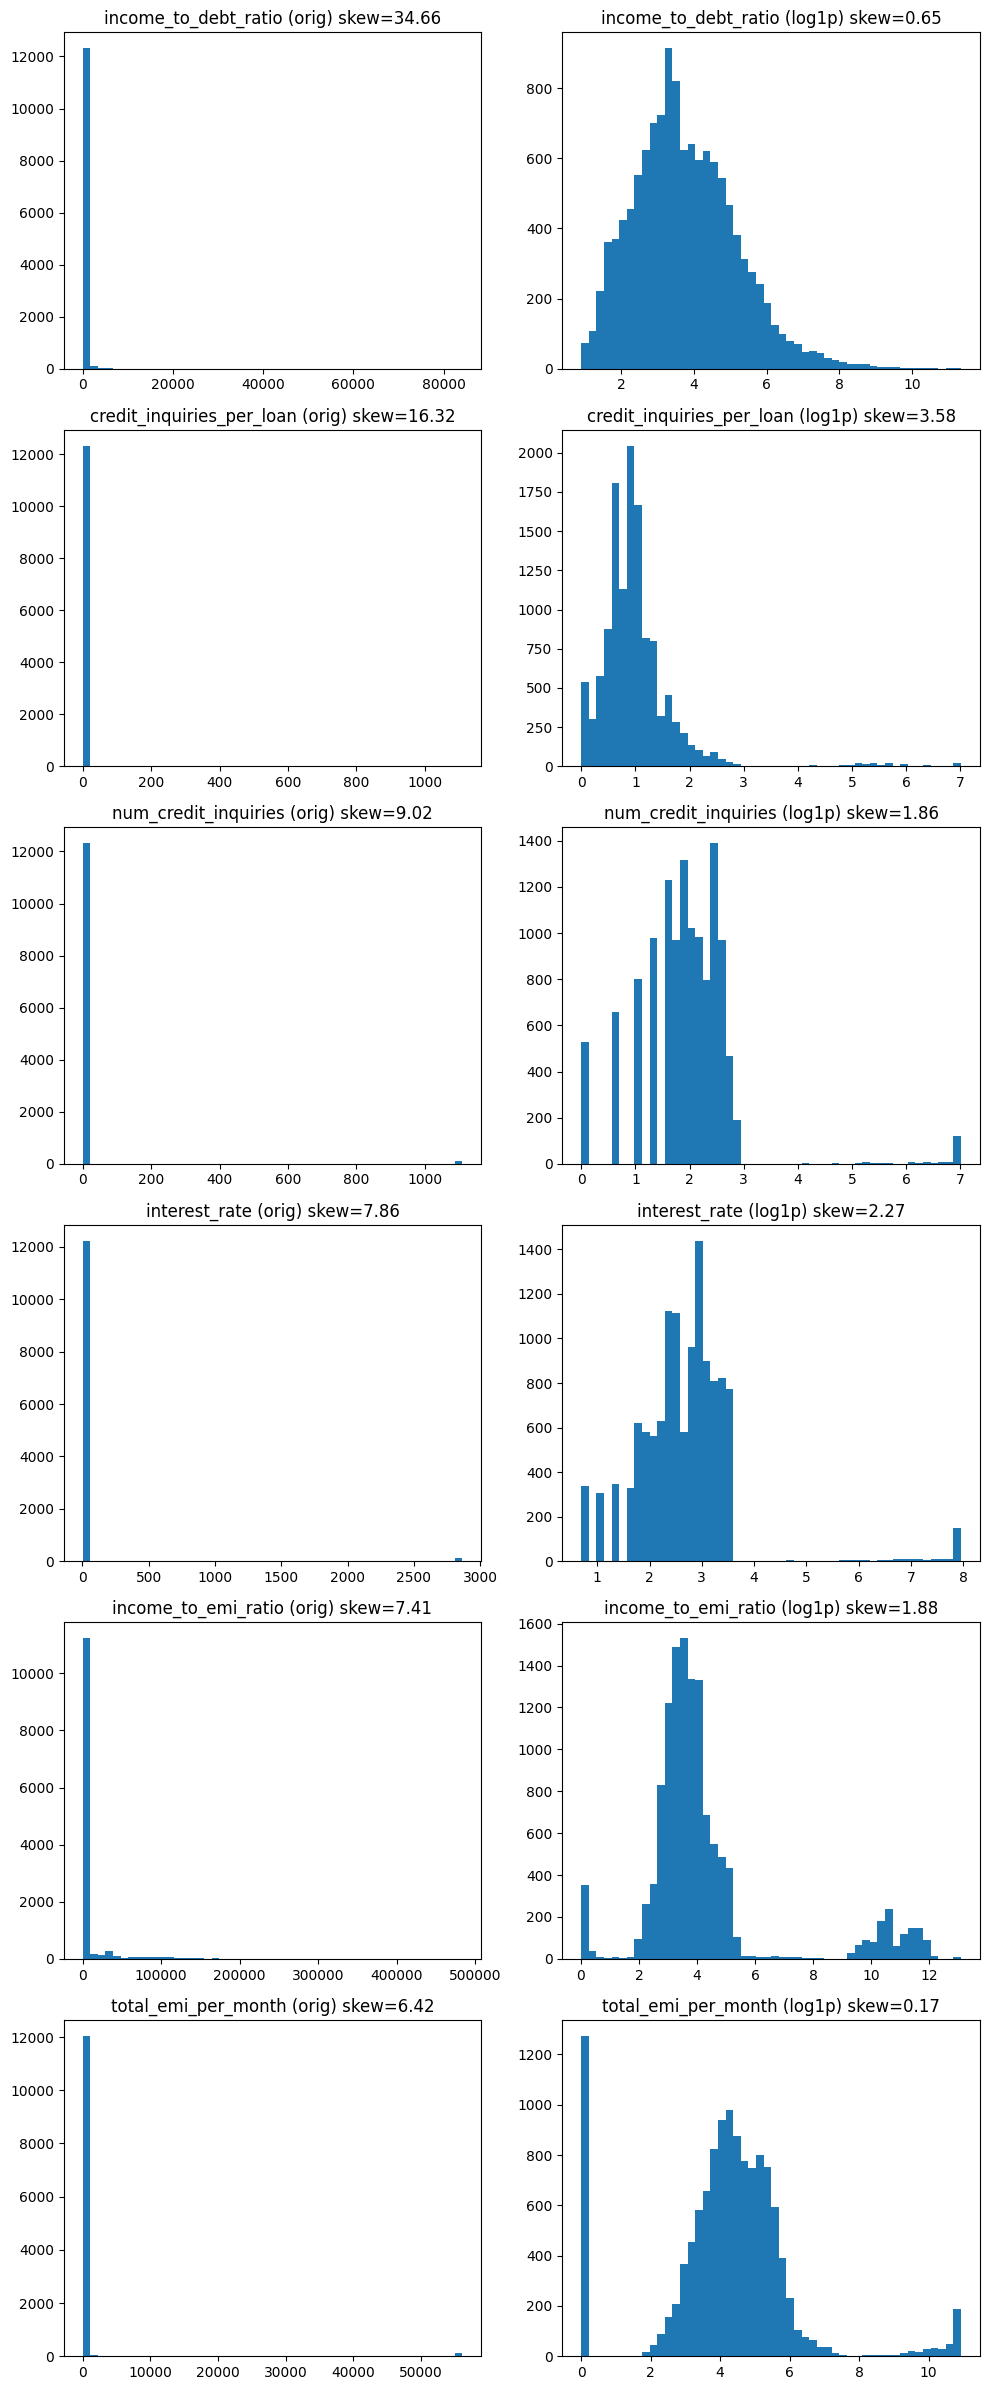

In [136]:
# Visual check: plot original vs log1p for top N skewed columns
import matplotlib.pyplot as plt
top_n = 6
cols_to_plot = columns_with_high_skew_values[:top_n] if columns_with_high_skew_values else skewness.head(top_n).index.tolist()

n = len(cols_to_plot)
if n:
    fig, axes = plt.subplots(n, 2, figsize=(10, 4*n))
    for i, col in enumerate(cols_to_plot):
        axes[i,0].hist(df[col].dropna(), bins=50)
        axes[i,0].set_title(f"{col} (orig) skew={skewness[col]:.2f}")
        axes[i,1].hist(np.log1p(df[col].dropna()), bins=50)
        axes[i,1].set_title(f"{col} (log1p) skew={np.log1p(df[col].replace({0:0})).skew():.2f}")
    plt.tight_layout()
    plt.show()
else:
    print("No skewed numeric columns found.")

In [137]:
for high_skew_col_name in columns_with_high_skew_values:
    col_name = f"{high_skew_col_name}_log1p"
    df[col_name] = np.log1p(df[high_skew_col_name])

df = df.drop(columns_with_high_skew_values, axis=1, errors="ignore")

/workspaces/customer-risk-prediction/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/workspaces/customer-risk-prediction/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [138]:
df.head(1).T

,0
customer_id,CUS_0x1000
month,August
age,18
delay_from_due_date,57
num_of_delayed_payment,26
changed_credit_limit,1.63
credit_utilization_ratio,30.077191
credit_score,Poor
credit_mix_Bad,True
credit_mix_Good,False


In [139]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.to_list()
numeric_cols

['age',
 'delay_from_due_date',
 'num_of_delayed_payment',
 'changed_credit_limit',
 'credit_utilization_ratio',
 'has_auto_loan',
 'has_credit_builder_loan',
 'has_debt_consolidation_loan',
 'has_home_equity_loan',
 'has_mortgage_loan',
 'has_not_specified',
 'has_payday_loan',
 'has_personal_loan',
 'has_student_loan',
 'credit_history_months',
 'month_num',
 'credit_score_numeric',
 'is_high_utilization',
 'income_to_debt_ratio_log1p',
 'credit_inquiries_per_loan_log1p',
 'num_credit_inquiries_log1p',
 'interest_rate_log1p',
 'income_to_emi_ratio_log1p',
 'total_emi_per_month_log1p',
 'avg_delay_days_log1p',
 'annual_income_log1p',
 'num_credit_card_log1p',
 'salary_to_loan_ratio_log1p',
 'num_of_loan_log1p',
 'amount_invested_monthly_log1p',
 'num_bank_accounts_log1p',
 'investment_to_salary_ratio_log1p',
 'monthly_balance_log1p',
 'monthly_inhand_salary_log1p',
 'outstanding_debt_log1p']

In [142]:
skewness = df[numeric_cols].skew().sort_values(ascending=False)
skewness.head(6)

/workspaces/customer-risk-prediction/.venv/lib/python3.12/site-packages/pandas/core/nanops.py:1256: RuntimeWarning: invalid value encountered in subtract
  adjusted = values - mean


credit_inquiries_per_loan_log1p     3.582344
interest_rate_log1p                 2.272396
income_to_emi_ratio_log1p           1.876481
num_credit_inquiries_log1p          1.863257
investment_to_salary_ratio_log1p    1.600326
delay_from_due_date                 0.966667
dtype: float64

!! Several columns still have high skew values:
- credit_inquiries_per_loan_log1p     3.582344
- interest_rate_log1p                 2.272396
- income_to_emi_ratio_log1p           1.876481
- num_credit_inquiries_log1p          1.863257
- investment_to_salary_ratio_log1p    1.600326